# Scientific Computing 5: Molecular dynamics (MD) simulation
This program simulates a gas of point-like particles in the microcanonical ensemble (fixed energy $E$, number of particles $N$ and volume $V$) with periodic boundary conditions in 3D with all particles having the same mass $M$.

To make the particles move, the Lennard-Jones potential is used with the force vector between a pair of particles $i$ and $j$, with $r_{ij} = \|{\vec{x}_j - \vec{x}_j}\|$:

$$\vec{f}(r_{ij}) = \frac{24\epsilon}{r_{ij}} \left(2 \left( \frac{\sigma}{r_{ij}} \right)^{12} - \left( \frac{\sigma}{r_{ij}} \right)^{6} \right) \frac{\vec{x}_j - \vec{x}_j}{\|{\vec{x}_j - \vec{x}_j}\|}$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from tqdm import tqdm

### Initalization
The simulation uses reduced units, with $m = 1$, $\epsilon = 1$ and $\sigma = 1$ and the following default parameters:

- Box size $L_x = L_y = L_z = 10$
- Number of particles $N = 100$
- Time step $h = 0.001$
- Minimum initial particle distance $r_{ij} \geq 0.9 \sigma$

The particles are placed randomly in the simulation box with the minimum distance $r_{ij}$. To move the particles, a symplectic time integration method is used to conserve the energy of the system. The method used is known as the semi-implicit Euler method.

The temperature is estimated using the following formula, with $k_B = 1$ in reduced units:

$T = \frac{2K}{3 k_B (N - 1)}$ &nbsp; where the kinetic energy &nbsp; $K = \frac{1}{2} \sum\limits_{i=1}^{N} m_i \|\vec{v}_i \|^2$

In [3]:
# Physical parameters:
N = 100  # number of particles
L = np.array([10, 10, 10])  # box size row vector [reduced units]
r_min = 0.9  # minimum distance between particles [reduced units]
r_cut = 2.5  # cutoff for interactions [reduced units]

cells = np.ceil(L/r_cut).astype(int)  # number of partitioning cells

# Simulation parameters:
h = 0.001  # time step size of the simulation [reduced units]
t_end = 50  # total time of the simulation [reduced units]

# Animation settings:
duration = 10  # video length [s]
FPS = 30  # video framerate [fps]

frames = duration * FPS  # total number of frames
steps_per_frame = int(round(t_end/h/frames))  # timesteps per frame

### Classes and functions

In [4]:
class Particle:
    def __init__(self):
        self.x = np.zeros(3)  # position
        self.v = np.zeros(3)  # velocity
        self.a = np.zeros(3)  # acceleration (= force in reduced units)

        self.c = np.zeros(3)  # cell index

    def clear_acceleration(self):
        self.a = np.zeros(3)
    
    def find_partitioning_cell(self):
        self.c = np.floor(self.x / r_cut).astype(int)
    
    def make_step(self):  # using semi-implicit Euler method
        self.v = self.v + h * self.a
        self.x = self.x + h * self.v

        self.K = 1/2 * np.linalg.norm(self.v)**2  # calculate kinetic energy
    
    def restrict_to_box(self):
        self.x = self.x - np.floor(self.x / L) * L

### Main code

In [5]:
particles = [Particle() for i in range(N)]

i = 0

while i < N:  # randomly place all particles in the box
    particles[i].x = np.random.default_rng().uniform(size=3) * L
    for j in range(i-1):
        dx = particles[j].x - particles[i].x
        dx = dx - np.round(dx / L) * L
        if np.linalg.norm(dx) < r_min:  # check particle distance
            i -= 1  # assign new location to particle if it is too close
            break

    i += 1

### Plot initialization
The initialized plot with the initialized box can be seen before the simulation is run.

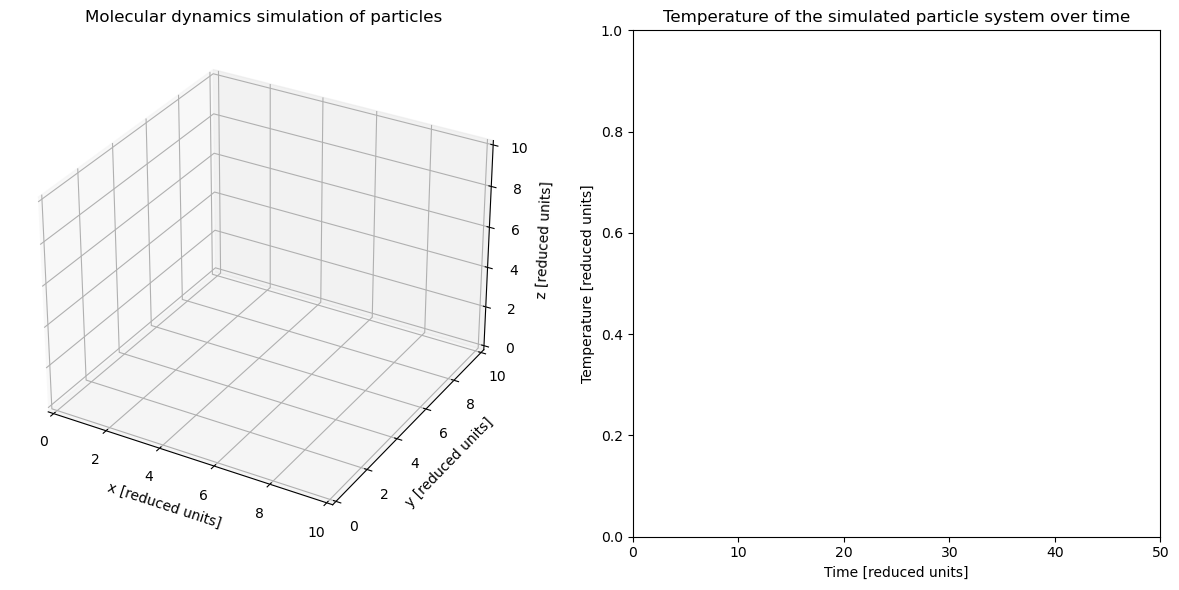

In [6]:
fig = plt.figure(figsize=(12, 6), dpi=100)

ax1 = fig.add_subplot(1, 2, 1, projection="3d")

ax1.set_xlim(0, L[0])
ax1.set_ylim(0, L[1])
ax1.set_zlim(0, L[2])

ax1.set_title("Molecular dynamics simulation of particles")
ax1.set_xlabel("x [reduced units]")
ax1.set_ylabel("y [reduced units]")
ax1.set_zlabel("z [reduced units]")

dots = []
for _ in range(N):
    dot = ax1.scatter([], [], [], marker="o")
    dots.append(dot)

ax2 = fig.add_subplot(1, 2, 2)

ax2.set_xlim(0, t_end)
ax2.set_ylim(0, 1)
ax2.set_title("Temperature of the simulated particle system over time")
ax2.set_xlabel("Time [reduced units]")
ax2.set_ylabel("Temperature [reduced units]")

lt, = ax2.plot([], [], color="k")

data = [dots, lt]
t, T = [], []

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

### Run the simulation
The simulation uses linked cell lists to partition the box and avoid a $\mathcal{O}(N^2)$ runtime, making the program more efficient for higher particle numbers. The particles are colored according to their velocity, which is updated in each simulation step.

In [7]:
def run_simulation(frame):
    for step in range(steps_per_frame):
        # Initialize linked cell lists:
        l_first = np.full(cells, -1)
        l_next = np.full(N, -1)

        for i in range(N):
            # Build linked cell list:
            particles[i].find_partitioning_cell()
            l_next[i] = l_first[tuple(particles[i].c)]
            l_first[tuple(particles[i].c)] = i
        
        for i in range(N):
            # Clear particle forces before calculating new interactions:
            particles[i].clear_acceleration()

        for i in range(N):
            ci = particles[i].c  # find cell coordinates
            cj = np.full(3, -1)

            for cjx in range(ci[0]-1, ci[0]+2):
                cj[0] = (cjx % cells[0])
                for cjy in range(ci[1]-1, ci[1]+2):
                    cj[1] = (cjy % cells[1])
                    for cjz in range(ci[2]-1, ci[2]+2):
                        cj[2] = (cjz % cells[2])

                        cj = cj.astype(int)
                        j = l_first[cj[0], cj[1], cj[2]]

                        while j != -1:
                            if j < i:
                                dx = particles[j].x - particles[i].x
                                dx = dx - np.round(dx / L) * L
                                r = np.linalg.norm(dx)  # calculate distance

                                if r < r_cut:
                                    # Calculate Lennard-Jones force in reduced units:
                                    f = 24/r * (2/r**12 - 1/r**6) * (dx / r)

                                    # Update forces between interacting particles:
                                    particles[i].a = particles[i].a - f
                                    particles[j].a = particles[j].a + f
                            
                            j = l_next[j]

        for i in range(N):
            particles[i].make_step()  # make time step
            particles[i].restrict_to_box()  # move particles to the box again

            # Update the position of the 3D scatter plot element:
            data[0][i]._offsets3d = ([particles[i].x[0]], [particles[i].x[1]], [particles[i].x[2]])

            velo = np.linalg.norm(particles[i].v)
            norm_velo = velo / np.max([np.linalg.norm(x.v) for x in particles])

            data[0][i].set_facecolors(cm.winter(norm_velo))  # set color according to color map

    t.append(round(frame * steps_per_frame * h, 2))
    T.append(2 * sum(x.K for x in particles) / (3 * (N-1)))

    data[1].set_data(t, T)

    progress.update(1)

    return data

### Save the simulation animation

In [8]:
progress = tqdm(total=frames+1)
ani = FuncAnimation(fig, run_simulation, frames=frames, interval=1000/FPS)
ani.save("output/molecular_dynamics_{N}_{FPS}fps.gif", fps=FPS)
progress = tqdm(total=frames+1)

100%|██████████| 301/301 [26:29:04<00:00, 316.76s/it]     
